In [4]:
import re
import time
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from transformers import BertModel
from sklearn.utils import shuffle
from utils import load_json, dump_json
from transformers import BertTokenizer
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from torch.utils.tensorboard import SummaryWriter  
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [6]:

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 256, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [12]:
len_train_step=3000
def initialize_model(epochs=10):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-7,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len_train_step * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [13]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [14]:
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device
device = get_device()

No GPU available, using the CPU instead.


In [15]:
epochs=5
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def load_checkpoint(filepath,optimizer):
    checkpoint = torch.load(filepath)
    model=checkpoint['modle']#提前网络结构
    model.load_state_dict(checkpoint['model_state_dict'])#加载网络权重参数
    optimizer=optimizer
    optimizer.load_state_dict(checkpoint['optimize_state_dict'])#加载优化器参数
    for parameter in model.parameters():
        parameter.requires_grad=False
    model.eval()
    return model
modle=load_checkpoint('checkoutpoints/checkpoint_epoch_5_lr_5e-7_dropout_0_warmupstep_0_seed_42.pkl',optimizer)

In [146]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [147]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.85, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [143]:
# specify a MAX_LEN you like
MAX_LEN=150
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent["sent1"]),#The first sequence to be encoded
            text_pair=text_preprocessing(sent["sent2"]),# second sequence to be encoded
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
#             return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [144]:
datas = load_json("ps_sents_pair_with_label.json")
#shuffle datas
datas = shuffle(shuffle(datas))
train,test = train_test_split(datas,test_size=0.2, random_state=2022)
test,val = train_test_split(test,test_size=0.5, random_state=2022)
#Convert  labels to torch.Tensor
train_labels = torch.tensor([t["label"] for t in train])
test_labels = torch.tensor([t["label"] for t in test])
val_labels = torch.tensor([t["label"] for t in val])
# 
train_inputs, train_masks = preprocessing_for_bert(train)
test_inputs, test_masks = preprocessing_for_bert(test)
val_inputs, val_masks = preprocessing_for_bert(val)
#Create PyTorch DataLoader

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([[-0.1252,  0.0233],
        [ 1.6808, -1.4288],
        [-0.1301,  0.2384],
        ...,
        [-0.5480,  0.6638],
        [ 0.9206, -1.0106],
        [ 1.7802, -1.6167]])
AUC: 0.5044
Accuracy: 77.94%


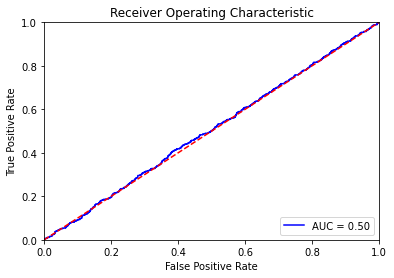

In [148]:
# Compute predicted probabilities on the test set
probs = bert_predict(modle, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, test_labels)

In [149]:
probs

array([[0.4629465 , 0.53705347],
       [0.95728683, 0.04271313],
       [0.40889925, 0.59110075],
       ...,
       [0.2293795 , 0.7706205 ],
       [0.8733852 , 0.12661475],
       [0.967606  , 0.03239404]], dtype=float32)

## 拓扑句子（依据bert二分类判别两句话的前后顺序）排序

In [150]:
from topological_sort import Graph
def sort_sentences(text_lst):
    data_lst = []
    for i in range(len(text_lst)):
        for j in range(i + 1, len(text_lst)):
            data_lst.append({"sent1": text_lst[i],"sent2":text_lst[j]})
    
    input_ids, attention_masks = preprocessing_for_bert(data_lst)
    input_data = TensorDataset(input_ids, attention_masks)
    test_sampler = SequentialSampler(input_data)
    test_dataloader = DataLoader(input_data, sampler=test_sampler, batch_size=4)
    probs = bert_predict(modle, test_dataloader)
#     print(probs)
    preds = probs[:, 1]
    graph, ind = Graph(probs.shape[0]), 0
    
    for i in range(len(text_lst)):
        for j in range(i + 1, len(text_lst)):
            if preds[ind] > 0.5:
                
                graph.add_edge(i, j)
            else:
                
                graph.add_edge(j, i)
            ind += 1
    print(graph.graph)
    sent_order = graph.topological_sort()
    return [text_lst[i] for i in sent_order]

In [151]:
import nltk
sp_text = '''My interest has been further stimulated by the impact Brexit has had on businesses. Due to the Brexit vote, businesses entered an interesting and challenging phase. The uncertainty over the UK's future relationship with the European Union is discouraging business investment as the pound depreciated in value immediately after the result, creating a challenge for firms based in the UK, as exports have become dearer and faced a fall in demand. This fuelled my curiosity for the accounting and financial side of business as I enjoy quantitative analysis and analysing strategies best for firms depending on their circumstances. I find the difficulties that businesses face very intriguing and would especially like to analyse business figures to help provide a solution to problems, such as cutting costs.
I attended a taster session for business management, as well as accounting and finance at City, University of London. This allowed me to not only explore the different options available, but also gain an insight into the skills needed to be successful. I learnt that application and analysis are skills that are very important and are needed to be successful, not only when studying towards a degree, but also when managing a business. Attending a placement at Barclays enabled me to explore the financial sector and gain an understanding into the role of a financial advisor. Some of the tasks I completed included aiding customers deposit money into their bank accounts, counting large amounts of money, and ensuring that the tills were balanced. I also got the chance to observe interviews between customers and advisors regarding the creation of new accounts and applications for loans.'''
sp_text_lst = nltk.sent_tokenize(sp_text) 
sp_text_lst

['My interest has been further stimulated by the impact Brexit has had on businesses.',
 'Due to the Brexit vote, businesses entered an interesting and challenging phase.',
 "The uncertainty over the UK's future relationship with the European Union is discouraging business investment as the pound depreciated in value immediately after the result, creating a challenge for firms based in the UK, as exports have become dearer and faced a fall in demand.",
 'This fuelled my curiosity for the accounting and financial side of business as I enjoy quantitative analysis and analysing strategies best for firms depending on their circumstances.',
 'I find the difficulties that businesses face very intriguing and would especially like to analyse business figures to help provide a solution to problems, such as cutting costs.',
 'I attended a taster session for business management, as well as accounting and finance at City, University of London.',
 'This allowed me to not only explore the different 

In [152]:
from sklearn.utils import shuffle
sp_text_lst = shuffle(sp_text_lst)
sp_text_lst

['Attending a placement at Barclays enabled me to explore the financial sector and gain an understanding into the role of a financial advisor.',
 'I find the difficulties that businesses face very intriguing and would especially like to analyse business figures to help provide a solution to problems, such as cutting costs.',
 'Due to the Brexit vote, businesses entered an interesting and challenging phase.',
 'This fuelled my curiosity for the accounting and financial side of business as I enjoy quantitative analysis and analysing strategies best for firms depending on their circumstances.',
 'I attended a taster session for business management, as well as accounting and finance at City, University of London.',
 'I learnt that application and analysis are skills that are very important and are needed to be successful, not only when studying towards a degree, but also when managing a business.',
 'My interest has been further stimulated by the impact Brexit has had on businesses.',
 "Th

In [153]:
# sorted_sentences = sort_sentences(sp_text_lst)[::-1]
sorted_sentences = sort_sentences(sp_text_lst)
for sent in sorted_sentences:
    print(sent)
    print("^-^")

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([[-0.2756,  0.3456],
        [ 0.0642, -0.1479],
        [-0.5867,  0.6431],
        [-0.6164,  0.6642],
        [-0.5303,  0.5561],
        [ 0.1041, -0.1584],
        [ 0.4456, -0.5468],
        [-0.6386,  0.6734],
        [-0.5503,  0.5530],
        [-0.5967,  0.6105],
        [-0.5777,  0.6666],
        [-0.6246,  0.7459],
        [ 0.2320, -0.2349],
        [-0.4941,  0.6373],
        [-0.5948,  0.6690],
        [-0.3769,  0.3405],
        [ 0.7736, -0.8781],
        [-0.0890,  0.0080],
        [-0.0475,  0.0400],
        [-0.3594,  0.3206],
        [ 0.3548, -0.4951],
        [-0.1476,  0.1321],
        [-0.6614,  0.7470],
        [-0.5624,  0.5337],
        [ 1.0909, -1.1485],
        [ 0.0518, -0.2348],
        [ 0.7585, -0.8209],
        [-0.6698,  0.7225],
        [-0.6674,  0.7550],
        [-0.2763,  0.1952],
        [-0.3701,  0.3014],
        [ 0.1697, -0.3540],
        [-0.4253,  0.2931],
        [-0.4662,  0.4099],
        [-0.5544,  0.6615],
        [ 0.8704, -0